## Fundamental extraction example

Use maelzel.snd.audiosample.Sample to load and manipulate an audio soundfile. A Sample can play itself (using csoundengine), has a nice html representation in jupyter with a waveform and browser playback.

In [1]:
from maelzel.snd import audiosample
import csoundengine
import numpy as np

Sample(dur=20.0, sr=44100, ch=1)
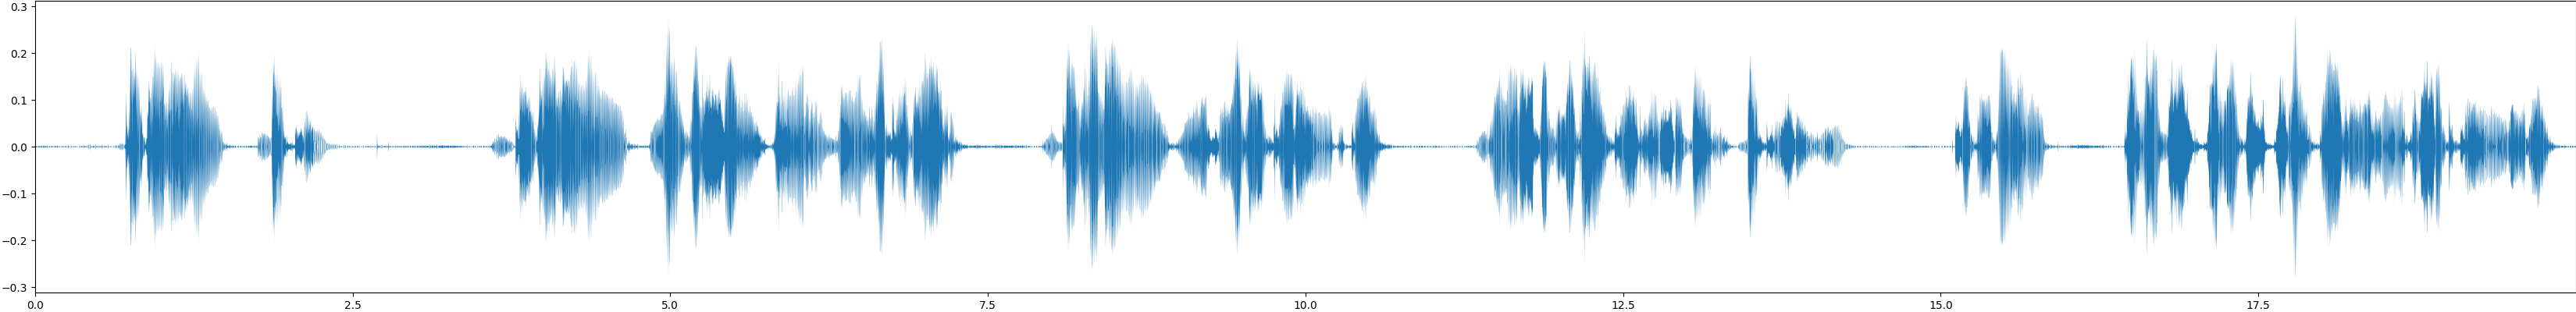

In [2]:
s = audiosample.Sample("snd/istambul2.flac")
s

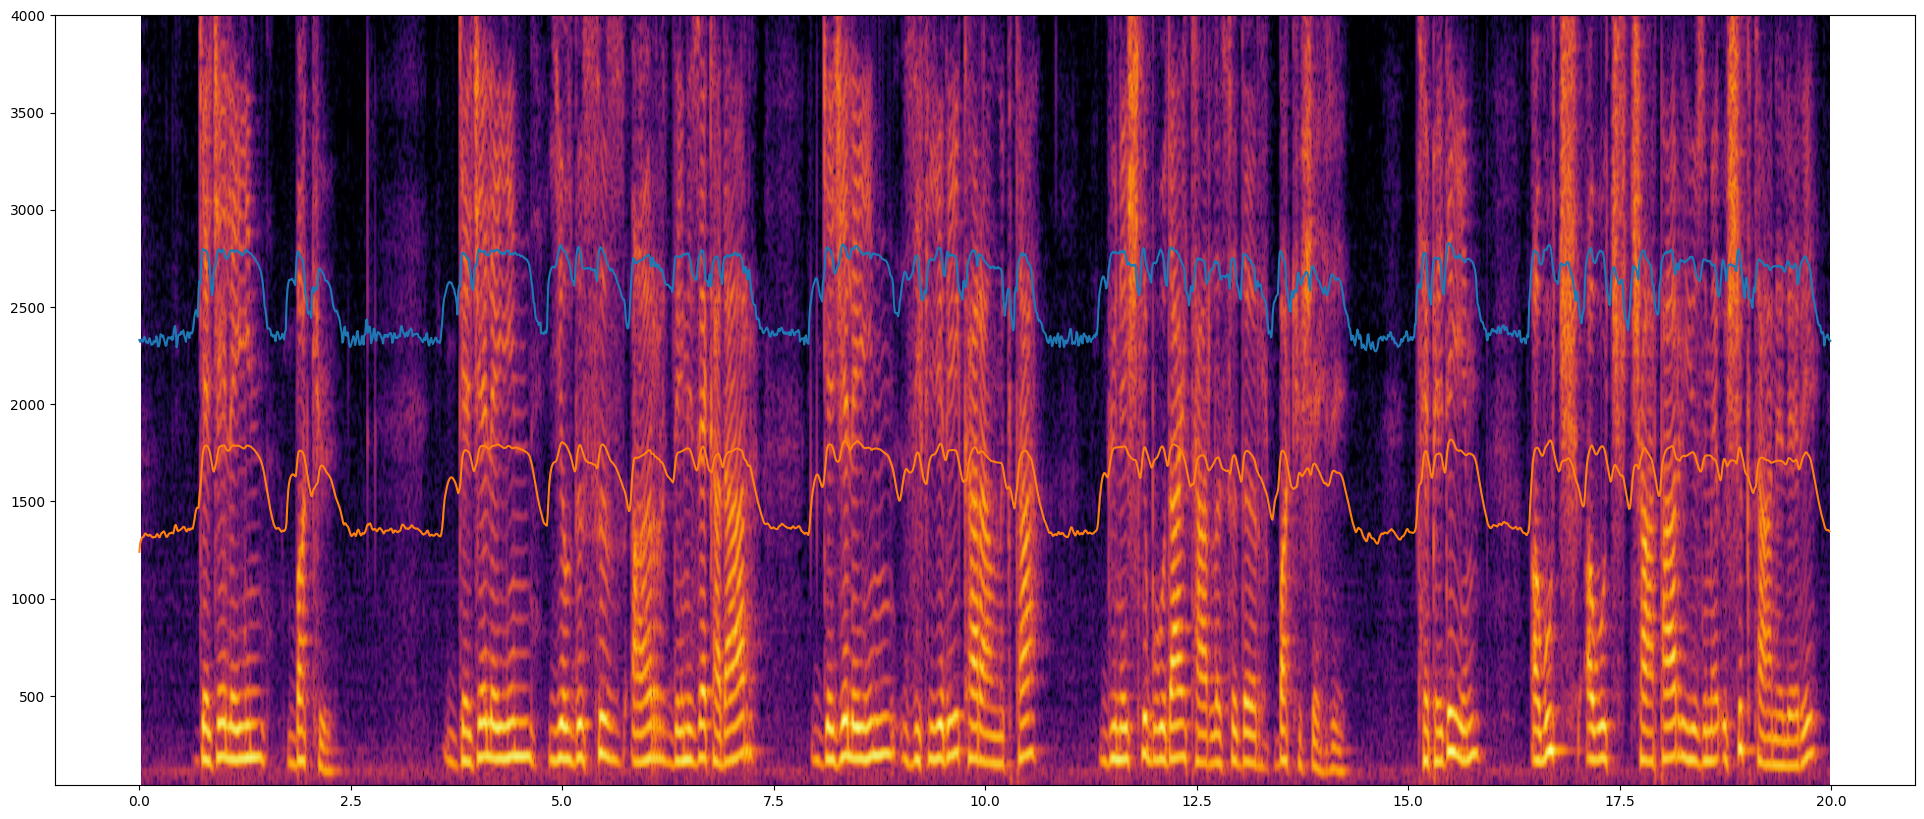

<Axes: >

In [3]:
axes = s.plotSpectrogram(maxfreq=4000, minfreq=40, fftsize=2048)
ampbpf = s.amplitudeBpf(attack=0.1, release=0.2, chunktime=0.02, overlap=2)
rms = s.rmsBpf(dt=0.02, overlap=2)

rms.amp2db().linlin(-90, 0, 2000, 3000).plot(n=2000, axes=axes, show=False)
ampbpf.amp2db().linlin(-90, 0, 1000, 2000).plot(n=2000, axes=axes)

### Extract the fundamental of and plot it against the spectrogram

LibXtract compiled with ooura FFT


mnOut size: 3446
m_pitchTrack size: 3446


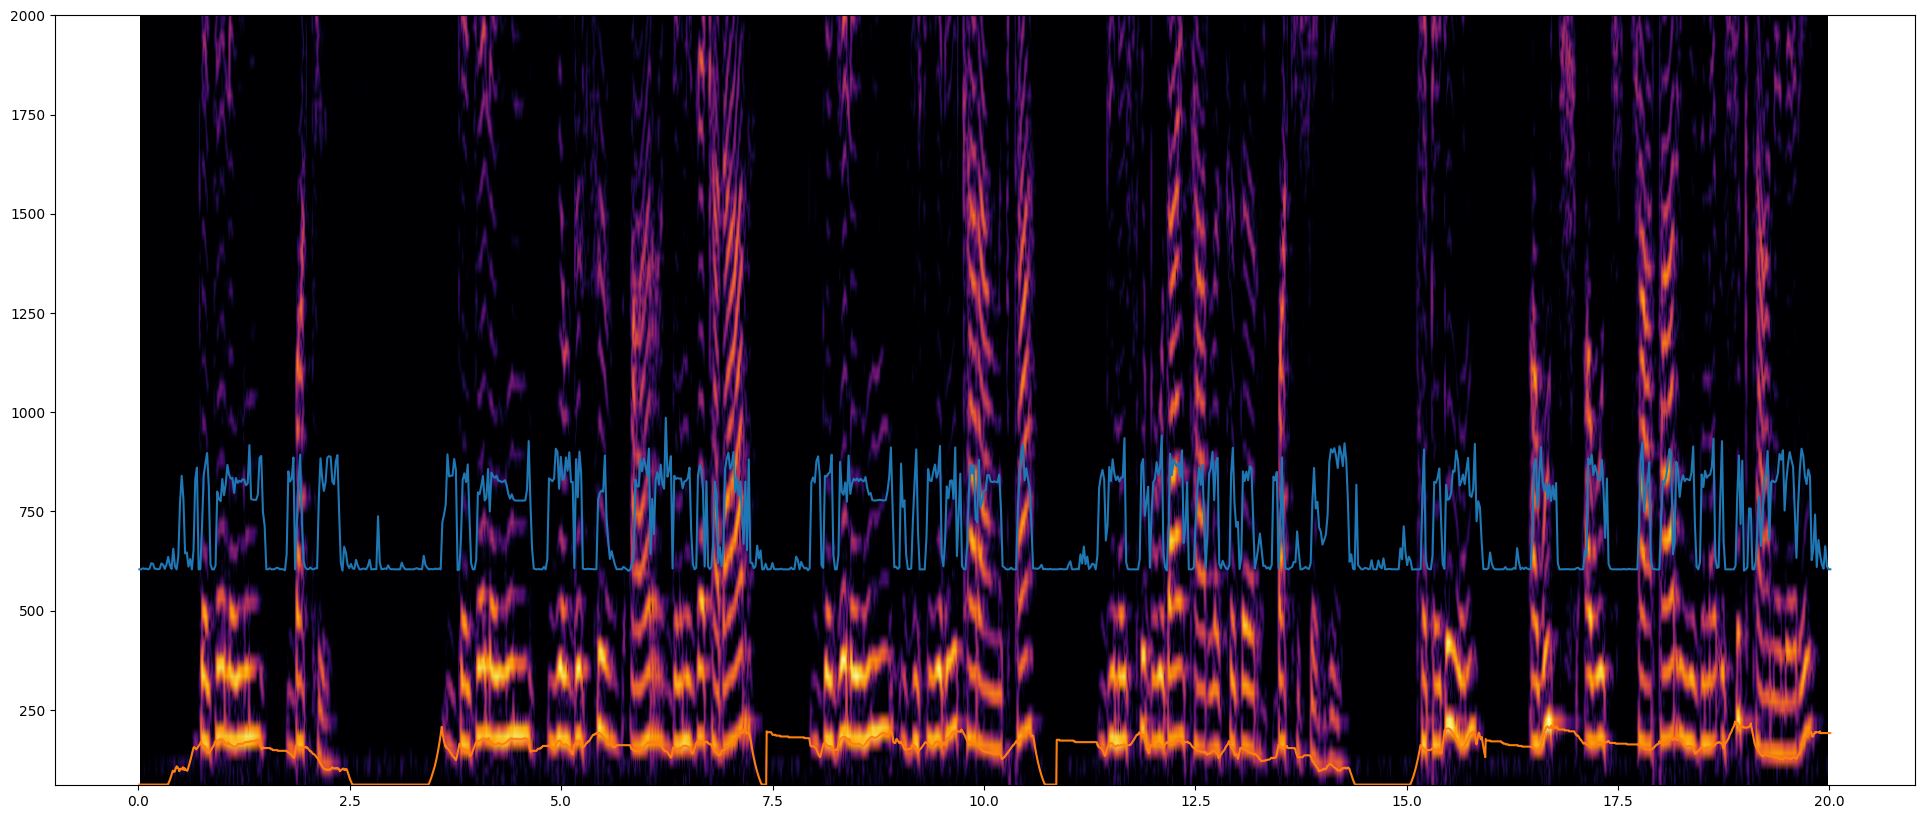

<Axes: >

In [4]:
fftsize = 2048
f0, voicedness = s.fundamentalBpf(fftsize=fftsize, overlap=8, unvoiced='nan')
axes = s.plotSpectrogram(maxfreq=2000, minfreq=60, fftsize=fftsize, overlap=4, mindb=-80)
voicedness.linlin(0, 1, 600, 1000).plot(n=1000, axes=axes, show=False)
f0valid = voicedness > 0.2
f0.plot(n=1000, axes=axes)


## Play the fundamental

Within csoundengine, we define an instr to play back the extracted fundamental as a square wave

In [5]:
session = csoundengine.Session()


using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


In [6]:
session.defInstr('vco', r'''
  |kfreq=200, kamp=0.1, igain=0.1, ichan=1|
  asig buzz 1, kfreq, 7, -1
  asig K35_lpf asig, 2000, 8
  aamp = interp(kamp*igain)
  asig *= lagud(aamp, 0.05, 0.05)
  outch ichan, asig
''')

Instr(vco, kfreq=200, kamp=0.1, igain=0.1, ichan=1)

In [7]:
amp = s.rmsBpf(dt=0.01, overlap=4) * 30
xs = np.arange(0, s.duration, 0.01)
freqs = f0.map(xs)
amps = amp.map(xs)
amps[f0valid.map(xs) == 0] = 0

### Play sample and fundamental simultaneously

When scheduling multiple events which need to be in sync with each other,
it is recommended to encapsulate all in a `lockedElapsedTime` block. Within 
such a block, time is "frozen" so that events are scheduled in the future using
the same reference time. Without this, the time it takes to schedule events
might lead to events falling out of sync

In [8]:
with session:
    f0synth = session.sched('vco', 0, dur=s.duration+0.1, kamp=0.1, ichan=2, kfreq=200)
    f0synth.automate('kfreq', (xs, freqs))
    f0synth.automate('kamp', (xs, amps))
    session.playSample((s.samples, s.sr), pan=0)    
session

Button(description='Stop Synths', style=ButtonStyle())

Output()

Session(engine0, backend=jack, outdev=Built-in Audio Analog Stereo, synths=2)

### Render to a soundfile


In [9]:
with session.rendering('tmp/fundamental.flac') as r:
    f0synth = r.sched('vco', dur=s.duration+0.1, kamp=0, ichan=2)
    f0synth.automate('kfreq', (xs, freqs))
    f0synth.automate('kamp', (xs, amps))
    r.playSample((s.samples, s.sr), pan=0, delay=fftsize/session.engine.sr)

r